In [7]:
from diffusers import AutoPipelineForText2Image
import torch
from pathlib import Path
import matplotlib.pyplot as plt

# Load the model
pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float16).to("cuda")

# Check that the file exists
path = Path("../models/sd_lora/sd_lora_output")
assert path.exists(), "File not found"

# Load the textual inversion embeddings
pipeline.load_lora_weights(path, weight_name="pytorch_lora_weights.safetensors")

image_list = []
for i in range(9):
    image_list.append(
        pipeline("A healthy cardiac image from a Samsung scanner", 
                                num_inference_steps=100,
                                # guidance_rescale=0.0,
                                ).images[0]
        )

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


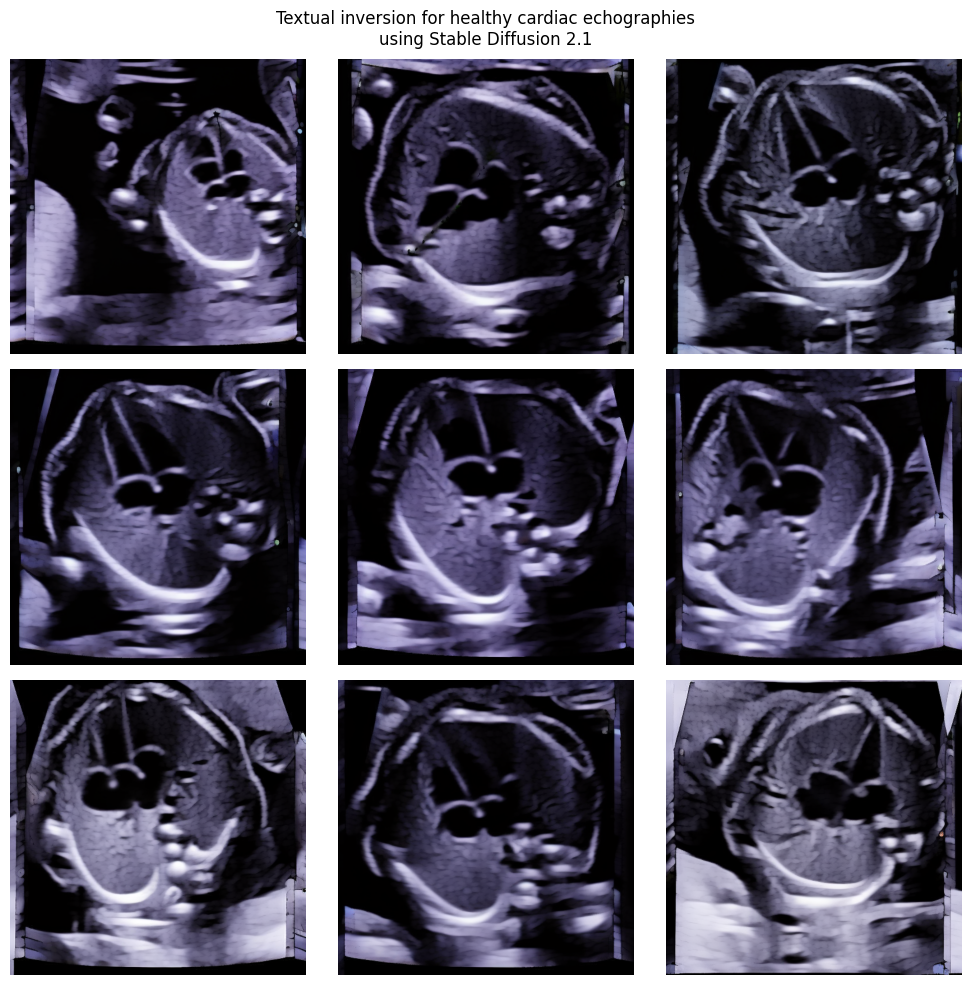

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(image_list[i])
    ax.axis("off")
fig.suptitle("Textual inversion for healthy cardiac echographies\nusing Stable Diffusion 2.1")
plt.tight_layout()
plt.show()